### The Gambling Game

Consider 2 coin machines, machine 0 and machine 1. Each machine dispenses a coin with an unkonwn probability. A player chooses between the 2 machine for the one that they think will give a coin. They get 135 chances/trials.  

If t is one such trial, then the following is true for t:

1. the probabilities of reward of the 2 machines add up to 1. 
2. the probability of reward of a machine is independent of that in any other trial. 
3. the player's choices do not influence the probabilities of reward in later trials. 

At https://hannekedenouden.ruhosting.nl/RLtutorial/Instructions.html, there is a set of data collected from 'students of the 2015 Computational Approaches to Cognitive Neuroscience Summerschool at the Donders Institute for Brain, Cognition and Behaviour, Radboud University Nijmegen.'. The data provided consists of some special datasets, each of which contains behavioral data of a student player. We have randomly selected 1 such dataset and loaded it here in the following code. 

In [187]:
import scipy.io as sio

In [188]:
# data from TaskReversalLearn\data\[some file].mat
datapath = '../../Documents/MATLAB/Modsoflearning/RLtutorial_codeNdata/taskReversalLearn/data/tutorialRevLearn_low_s014_data.mat'
data = sio.loadmat(datapath, squeeze_me=True, struct_as_record=False)

This dataset consists(not exclusively) of the following: 
1. choices made by the student player over all trials
2. feedback/reward from the machines over all trials
3. feedback probabilities from a machine over all trials

In [189]:
# choices = data.choice - 1 (black dots) 
# print(data.keys())
choices = data['data'].choice
modifiedchoices = choices - 1
r = data['data'].prep.feedback

In [190]:
# probability of reward of one of the machines 
probblue = data['data'].prep.feedbackprob
probblue

array([ 0.7,  0.7,  0.7,  0.7,  0.7,  0.7,  0.7,  0.7,  0.7,  0.7,  0.7,
        0.7,  0.7,  0.7,  0.7,  0.7,  0.7,  0.7,  0.7,  0.7,  0.7,  0.7,
        0.7,  0.7,  0.7,  0.7,  0.7,  0.7,  0.7,  0.7,  0.7,  0.7,  0.7,
        0.7,  0.7,  0.3,  0.3,  0.3,  0.3,  0.3,  0.3,  0.3,  0.3,  0.3,
        0.3,  0.3,  0.3,  0.3,  0.3,  0.3,  0.3,  0.3,  0.3,  0.3,  0.3,
        0.3,  0.3,  0.3,  0.3,  0.3,  0.3,  0.3,  0.3,  0.3,  0.3,  0.7,
        0.7,  0.7,  0.7,  0.7,  0.7,  0.7,  0.7,  0.7,  0.7,  0.7,  0.7,
        0.7,  0.7,  0.7,  0.7,  0.7,  0.7,  0.7,  0.7,  0.7,  0.7,  0.7,
        0.7,  0.7,  0.7,  0.7,  0.7,  0.7,  0.7,  0.7,  0.7,  0.7,  0.7,
        0.7,  0.3,  0.3,  0.3,  0.3,  0.3,  0.3,  0.3,  0.3,  0.3,  0.3,
        0.3,  0.3,  0.3,  0.3,  0.3,  0.3,  0.3,  0.3,  0.3,  0.3,  0.3,
        0.3,  0.3,  0.3,  0.3,  0.3,  0.3,  0.3,  0.3,  0.3,  0.3,  0.3,
        0.3,  0.3,  0.3])

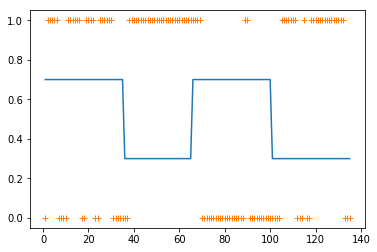

In [191]:
# plot choices and feedback probabilities against trials
trials = list(range(1, len(modifiedchoices)+1, 1))
import matplotlib.pyplot as plt
plt.plot(trials, probblue, '-', trials, modifiedchoices, '+')
plt.show()

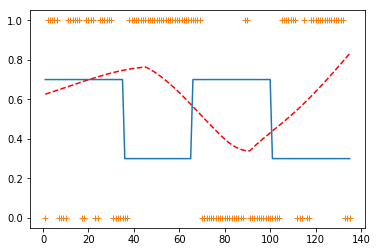

In [192]:
# add smoothed choice
# there are many ways of doing this. Here we use lowess
import statsmodels.api as sm
lowess = sm.nonparametric.lowess
smoothedchoice = lowess(modifiedchoices, trials)

plt.plot(trials, smoothedchoice[:, 1], 'r--', trials, probblue, '-', trials, modifiedchoices, '+')
plt.show()

In [193]:
# Want to make sure that exactly 1 machine gives a coin at every trial 
test = np.sum(r, axis = 1)
test
# we can see how many 1's there are in this case because the dataset is small enough 
# in practice, datasets can be very large, so to confirm that test indeed is an array of sums, we do the following:
if np.sum(test).astype(int) == len(test):
    print(True)
else:
    print(False)

True


## Learning
We use two learning models in this notebook. 

### I. Reinforcement Learning
<br>
**1.1.1 Definitions**
1. For each trial, we associate a value between 0 and 1 with each machine called the **stimulus value**. Let $v_{i ,s}$ be the stimulus value of machine $s$ at trial $i$, then $v_{i, 1-s} = 1-v_{i, s}$.
2. $r_{i, s}$ is the reward/feedback from machine s at trial $i$. 
3. $\alpha$ is a parameter between 0 and 1. We will explore the effects of varying it later, and then find a possible interpretation for it. 
4. $cp_{i, s}$ is the probability of choosing machine s at trial $i$. 
5. $\beta$ is a non-negative parameter. Again we will explore this further later.

<br>
**1.1.2 Theory**


The **Rescorla-Wagner Equation** is a way of updating stimulus values of each machine using the reward from the machine chosen in the most recent trial and the parameter $\alpha$. 
    $$v_{i+1, s} = v_{i, s} + \alpha(r_{i, s} - v_{i, s})$$
<br>
The new stimulus values are used to generate choice probabilities for the upcoming trial using the **Softmax Equation**:
    $$cp_{i+1, s} = \frac{exp(\beta v_{i+1, s})}{\sum_{s \in \Omega_{s}}\beta v_{i+1, s}}$$    
<br>
where $\Omega_{s}$ is the set of values $s$ takes. 

<br>
**1.1.3 Quick Summary**

Roughly speaking, this is what we will do:
1. take stimulus value for each machine 
2. use Softmax to generate choice probabilities 
3. toss a biased coin to generate a choice from the choice probabilities 
4. get reward 
5. plug into Rescorla Wagner to get new stimuli values 
6. repeat

**NOTE**

Whenever a variable takes values over continuous sets, we discretise the set so that the variables are accurate up to 2 decimal places. 

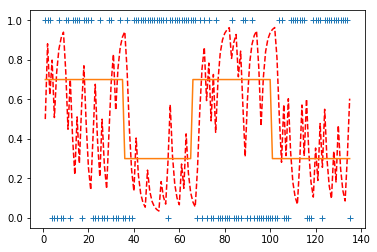

In [194]:
# Simulate individual behavior  

import numpy as np

# parameter values
alpha = 0.25
beta = 4

def Simulate(alpha, beta):
    # rewards
    r = data['data'].prep.feedback

# matrix of stimuli values 
    v = np.zeros((135, 2), dtype = float)
# matrix of choice probabilities 
    cp = np.zeros((135, 2), dtype = float)
# matrix of choices 
    c = np.zeros(135, dtype=int)
# c[i] = choice at trial i + 1 

# set initial values 
    v[0, :] = [0, 0]
# stim[i, :] = stimuli from trial i
    cp[0, :] = [1/2, 1/2] 
# cp[i, :] = probabilities of choosing each machine at trial i + 1
    loglik = 0
# log likelihood for data fitting 
    loglikopt = 0 
# log likelihood for optimal performance

    for i in range(0, 134): 
# generate random number between 0 and 1 
        h = np.random.random_sample(1)
        if h <= cp[i, 0]: 
            c[i] = 0
        else: 
            c[i] = 1
        
# substitute into RW equation to get new stimulus for chosen machine 
# RW equation: 
        s = c[i]
        v[i+1, s] = v[i, s] + alpha*(r[i, s] - v[i, s])
        v[i+1, 1-s] = 1-v[i+1, s]
    
# then substitute two stimuli into softmax equation to get choice probability for machine s 
# Softmax equation:
        cp[i+1, s] = (np.exp(beta*v[i+1,s]))/(np.exp(beta*v[i+1,0]) + np.exp(beta*v[i+1,1]))
        cp[i+1, 1-s] = 1 - cp[i+1, s]
            
# compute log likelihoods for optimal performance 
        if r[i, 1] == 1:
            loglikopt = loglikopt + np.log(cp[i, 1])
        else:
            loglikopt = loglikopt + np.log(cp[i, 0])

    return c, cp, loglikopt

c, cp, loglikopt = Simulate(alpha, beta)

# plot choices, choice probabilities and feedback probabilites against trial number
plt.plot(trials, c, '+', trials, cp[:, 0], 'r--', trials, probblue, '-')
plt.show()

**1.2.1 Exploring $\alpha$**

We fix $\beta$ and see what varying $\alpha$ does to the model. 

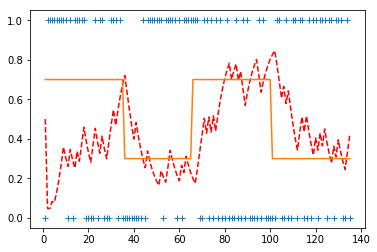

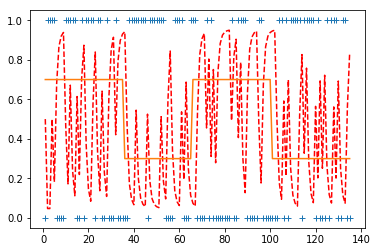

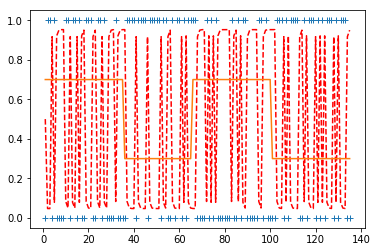

In [195]:
# Explore what changing alpha does to the behavior of the model 
# we run the above code for different values of alpha, for instance,
alpha = [0.1, 0.5, 0.9]
# beta is fixed 
beta = 3 

# run simulation for chosen values of alpha and beta
c0, cp0, loglikopt0 = Simulate(alpha[0], beta)
c1, cp1, loglikopt1 = Simulate(alpha[1], beta)
c2, cp2, loglikopt2 = Simulate(alpha[2], beta)

# plot 
plt.plot(trials, c0, '+', trials, cp0[:, 0], 'r--', trials, probblue, '-')
plt.show()
plt.plot(trials, c1, '+', trials, cp1[:, 0], 'r--', trials, probblue, '-')
plt.show()
plt.plot(trials, c2, '+', trials, cp2[:, 0], 'r--', trials, probblue, '-')
plt.show()

As $\alpha$ increases, the difference in choice probabilities of trial $i$ and trial $i$+1 increases for all $i > 1$. So it can be interpreted as the sensitivity to reward and punishment. 

**1.2.2 Exploring $\beta$**

If $\beta$ is negative, then for any given pair of stimuli $v$ and $1-v$, the smaller stimuli yields a higher choice probability, which is silly. 

So $\beta$ is a non-negative real number. 

Notice that if $\beta$ = 0, then choice probability = 0.5.  

If take limit $\beta \rightarrow \infty$, then choice probability converges to 0. 

One way of finding out a possible interpretation of $\beta$ is to do some plots. There are many plots you can do but a particularly useful thing to do is to plot the choice probabilities for a machine over a range of differences between the stimulus values for several values of $\beta$. 

I say several values of $\beta$ because we cannot include all possible values of $\beta$ in the plot. There are many different ways of constraining the values of this parameter. The simplest is to set an arbitrary hard bound.

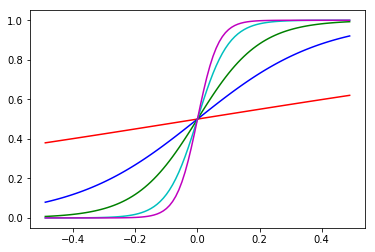

In [196]:
# there are 1, ..., 99 different pairs of stimuli values whose difference is 0.99, ..., 0.01
# so we have to choose a pair of stimuli values for pairs whose difference < 0.99
# for simplicity we pick a fixed v2 
v2 = 0.5
v1 = np.arange(0.01, 1, 0.01)
diff = np.zeros(99)
for j in range(0, 99):
    diff[j] = v1[j] - v2

# choice probabilities
def choiceprobsdiff(bv):
    cpd = np.zeros(99)
    for i in range(0, 99):
        cpd[i] = np.exp(bv*v1[i])/(np.exp(bv*v1[i]) +np.exp(bv*v2))
    return cpd 

# plot for several values of beta 
plt.plot(diff, choiceprobsdiff(1), 'r-', diff, choiceprobsdiff(5), 'b-', diff, choiceprobsdiff(10), 'g-', diff, choiceprobsdiff(20), 'c-', diff, choiceprobsdiff(30), 'm-')
plt.show()

If $\beta_{1} \leq \beta_{2}$, $s$ is the machine with a higher stimulus value, and $cp_{1}, cp_{2}$ are the choice probabilities of machine $s$, then $cp_{1} \leq cp_{2}$. $\beta$ is like the ability to learn from stimulus. It is in fact called the Learning Rate.

**1.3 Hyperparameter Optimisation**

Can we set the values of $\alpha$ and $\beta$ so that we get the optimal performance of the model in the gambling game with this particular sequence of feedback probabilities? There are many ways to achieve this. Here, we use Grid Search.

We run model over all possible parameter settings to find out which one gives the maximal probability of feedback probabilities = choice probabilities of model i.e. we find the maximum likelihood estimator alpha and beta.

This is the parameter setting that gives the best performance using this model. 

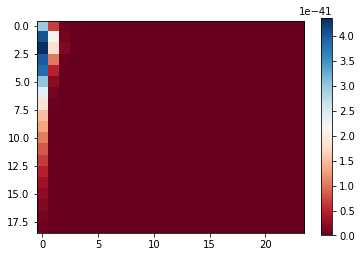

[ 0.95  0.  ]
[19.0, 0.0]


In [197]:
# Grid Search for model that gives optimal performance 
# instead of adding up the log likelihoods of getting the choices in the given data, 
# we add up log likelihoods of choosing the right machines based on data.prep.feedback 
            
def Likelihoodopt(alpha, beta): 
    c, cp, loglikopt = Simulate(alpha, beta)
    likopt = np.exp(loglikopt)
    return likopt

parama = np.arange(0, 1, 0.05)
paramb = np.arange(0, 15, 0.6)

Likopt = []

for alpha in parama:
    for beta in paramb:
        Likopt = np.append(Likopt, Likelihoodopt(alpha, beta))
        
# plot likelihoods
from pylab import cm,imshow,colorbar,axis,show
# could just plot this but would include all cases in which alpha = 0 and beta = 0, which are silly cases
Likopt = Likopt.reshape((20, 25))
# here we delete silly cases
Likoptnonzero = []
for i in range(1, 20):
    for j in range(1, 25):
        Likoptnonzero = np.append(Likoptnonzero, Likopt[i ,j])
Likoptnonzero = Likoptnonzero.reshape(19, 24)
im = imshow(Likoptnonzero, cmap=cm.RdBu)
colorbar(im)
show()         

# find maxima
mleopt = np.zeros(2)
for a in list(range(0, len(parama))): 
        for b in list(range(0, len(paramb))):
            if Likopt[a, b] == np.amax(Likopt):
                mleopt[0] = a*0.05
                mleopt[1] = b*0.6  
print(mleopt)
print([mleopt[0]/0.05, mleopt[1]/0.6])
# this is sometimes not an integer - why?
# probably because the alphas and betas are not stored exactly
# if more than 52 decimal places are required, then it'll be an approximate value

Let $(i, j)$ be integral coordinates on the grid. Then the likelihood of $(i, j)$ is the likelihood of the $i$-th value of alpha and the $j$-th value of beta.  

1. Why does the mle change everytime? 
<br>
Because everytime the model runs, the first choice generated only has a 0.5 probability of being the same as the one before. Then the stimulus for the first trial might change, and if so so would the choice probability, and so on and so forth. Since loglik is the sum of all logs of choice probabilities, it would also be different from before.
2. Why are a and b sometimes not integers? 
<br>
In the cases where the corresponding alpha and beta values are infinite decimals, only finitely many decimals are stored.  

**1.4 Data Fitting** 

We now fit the model to the data. The rough algorithm is as follows: 
1. start with initial stimulus value for each machine 
2. compute choice probability for each machine 
3. get player choice and corresponding outcome from dataset 
4. use above to update stimulus value $v$ of chosen machine 
5. stimulus value of other machine is $1 - v$ 
6. repeat

In [198]:
# Data fitting function 

def Fit(alpha, beta):
    v = np.zeros((135, 2))
    v[0, :] = [0, 0]
    
    cp = np.zeros((135, 2))
    cp[0, :] = 0.5*np.ones((1, 2))
    
    loglik = 0
    
    c = modifiedchoices
    
    r = data['data'].prep.feedback
    
    for i in range(0, 134):
        cp[i, 0] = np.exp(beta*v[i, 0])/(np.exp(beta*v[i, 0]) + np.exp(beta*v[i, 1]))
        cp[i, 1] = 1 - cp[i, 0]
        
        s = c[i] 
        v[i+1, s] = v[i, s] + alpha*(r[i, s] - v[i, s]) 
        v[i+1, 1-s] = 1-v[i, s]
        
        if data['data'].choice[i] == 1:
            loglik = loglik + np.log(cp[i, 0])
        else:
            loglik = loglik + np.log(cp[i, 1])
    
    return loglik

Now we plot the likelihood landscape and find the maximum likelihood estimators of alpha and beta for this particular dataset.

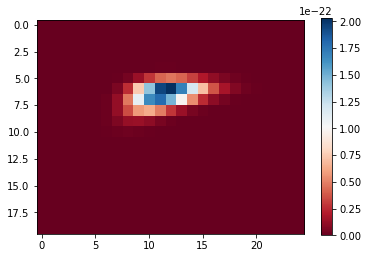

[ 0.3  7.2]
[  6.  12.]


In [199]:
def Likelihood(alpha, beta): 
    loglik = Fit(alpha, beta)
    lik = np.exp(loglik)
    return lik

alpha = np.arange(0, 1, 0.05)
beta = np.arange(0, 15, 0.6)

Lik = []

for alpha in parama:
    for beta in paramb:
        Lik = np.append(Lik, Likelihood(alpha, beta))
        
# plot likelihoods
from pylab import cm,imshow,colorbar,axis,show
# could just plot this but would include all cases in which alpha = 0 and beta = 0, which are silly cases
Lik = Lik.reshape((20, 25))
# here we delete silly cases
Liknonzero = []
for i in range(1, 20):
    for j in range(1, 25):
        Liknonzero = np.append(Liknonzero, Lik[i ,j])
Liknonzero = Liknonzero.reshape(19, 24)
im = imshow(Lik, cmap=cm.RdBu)
colorbar(im)
show() 

# maxima  
mle = np.zeros(2)
coords = np.zeros(2)
for a in list(range(0, 20)): 
        for b in list(range(0, 25)):
            if Lik[a, b] == np.amax(Lik):
                mle[0] = a*0.05
                mle[1] = b*0.6
                coords[0] = a
                coords[1] = b
print(mle)
# if the coords of a likelihood is (i, j), then the likelihood is that of the ith value of alpha and the jth value of beta
print(coords)

Rather than computing the coordinates directly as above, we can slice the landscape at fixed values of beta and alpha to get the marginal distribution of each. The maxima of those distributions should give the same mles. 

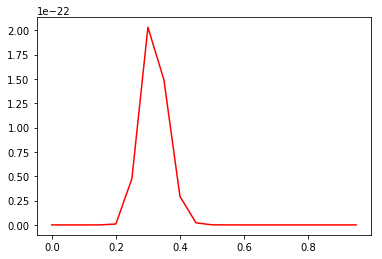

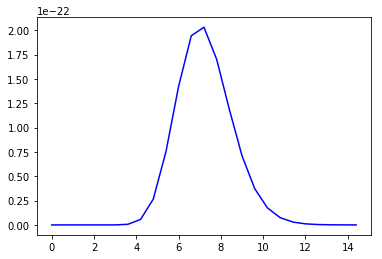

In [200]:
# marginal distributions 
# computation: 
# md for alpha
tmpa= np.sum(Lik, axis = 0)
# md for beta 
tmpb = np.sum(Lik, axis = 1)
# normalisation constant for alpha
na = np.sum(tmpa)
# for b 
nb = np.sum(tmpb)
# mda 
mda = np.divide(tmpa, na)
# mdb 
mdb = np.divide(tmpb, nb)

# slice the landscape
# choose values for alpha and beta to slice the landscape along
# for instance the maximum likelihood estimators 
# numpy.astype needed because values were previously stored as floating points
a = coords[0].astype(int) 
b = coords[1].astype(int)
plt.plot(parama, Lik[:, b], 'r-')
plt.show() 
plt.plot(paramb, Lik[a, :], 'b-')
plt.show()

As expected, the values corresponding to the peaks are consistent with the values obtained directly in the preceding block of code. 

### II. Bayesian Learning
Rough Learning Algorithm: 
1. Let $q$ be the probability that machine 0 gives a coin
2. Set an initial probability distribution for the values that $q$ can take. We use the uniform distribution over the discretised interval [0, 1]. 
3. Get outcome of trial 1: 
<br> if machine 1 gives a coin, then the likelihood of $q$ is $q$ 
<br> else the likelihood is $1-q$
4. Use Bayes theorem to get the posterior distribution 
5. At this point the model uses this distribution as the prior for trial 2 with probability $1-H$, and the uniform distribution with probability $H$. $H$ is called the transition probability. 
6. After obtaining the new prior, repeat all steps until last trial.

In [201]:
# Bayesian Learning

H = 1/25 # as per the tutorial - do not know what a good way to decide this is

q = np.arange(0.01, 0.99, 0.01)
def Bayes(H):
    
# Let q be the probability that machine 0 gives a coin 
    q = np.arange(0.01, 0.99, 0.01)

# the prior distribution is uniform 
    prior = np.zeros((135, len(q)))
    prior[0] = (1/len(q))*np.ones(len(q))
    post = np.zeros((134, len(q)))
    
# p[i] is the prob distr for q for trial[i]  

    for i in range(0, 134):
        if r[i, 1] == 1: 
            post[i] = np.multiply(q, prior[i])/np.sum(np.multiply(q, prior[i])) # normalised posterior
        else:
            post[i] = np.multiply(1-q, prior[i])/np.sum(np.multiply(1-q, prior[i]))

# now for the prior for trial i + 1 
        prior[i+1] = (1-H)*post[i] + H*np.ones(len(q))/(len(q))
    return prior

**2.1 Estimate $q$**
<br>
We can estimate the value of $q$ by taking the expected value of $q$ at each trial. 
<br>

**2.1.1 Distribution of $q$**
The prior and posterior distributions of the n-th trial are polynomials of degree $n-1$ and $n$. Indeed,


prior[1] = $1/99$
<br>
post[1] = $q/99$
<br>

Every time post[$i$] becomes prior[$i+1$], the degree of $q$ is unchanged. All that is done is a multiplication by a constant and an addition by a constant i.e. a scaling and a translation. 
<br>
Every time prior[$j$] becomes post[$j$], the degree of $q$ increases by 1.

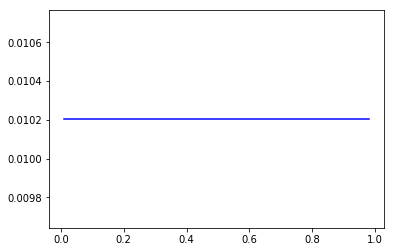

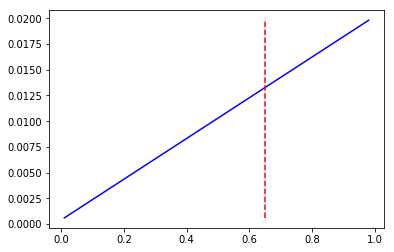

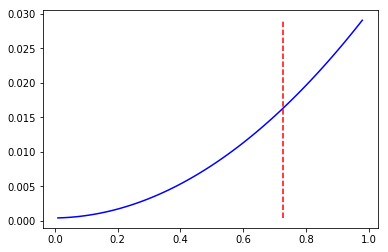

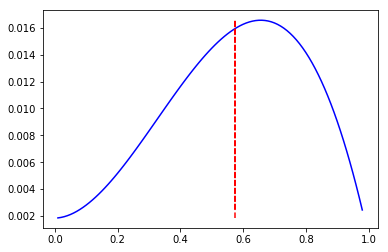

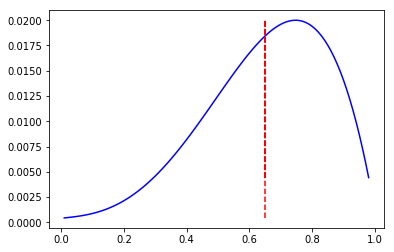

In [202]:
# Plot prior distributions for each trial together with the expected value of q
# We expect these to be polynomials in q of increasing degree

H = 0.04

# Expected value of q using priors for trial i
eq = np.zeros(135)
for i in list(range(0, 135)): 
    eq[i] = np.sum(np.multiply(Bayes(H)[i], q))

eqplt = np.zeros((len(eq), len(q)))
for k in list(range(0, 135)):
    eqplt[k, :] = eq[k]*np.ones(len(q))
    
for i in range(0, 5):
    plt.plot(q, Bayes(H)[i], 'b-', eqplt[i], Bayes(H)[i], 'r--')
    plt.show()

**2.1.1 Strength of Estimate**

To see the strength of the estimates more easily, we plot the true feedback probabilities together with expected values of q over all trials for the chosen value of $H$. 

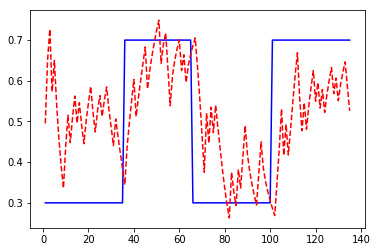

In [203]:
probor = 1-probblue
plt.plot(trials, probor, 'b-', trials, eq, 'r--')
plt.show()

**2.1.2 Point of Reversal**

You'll notice from plotting the feedback probability that this game is a set of trials partitioned into 4 sets, each of which contains trials that share the same feedback probability for machine 0. 

A **point of reversal** is the last trial of a partition.

The change in value of the estimate of $q$ around a point of reversal can be interpreted as the model's reaction to a sudden change in reward. From the above you can see that there is a delayed response at every point of reversal. So we should expect the first few trials succeeding the point of reversal to 'ignore' the change in reward and at some point decide not to 'ignore' it. 

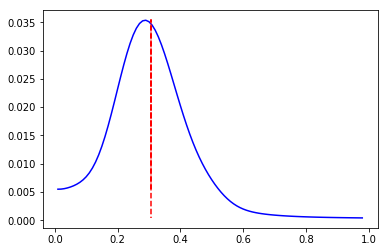

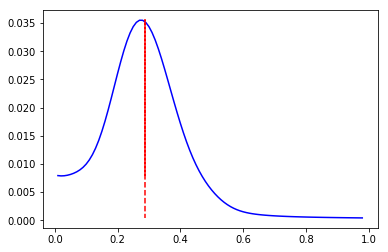

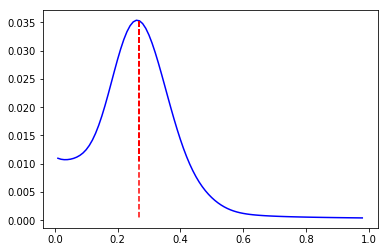

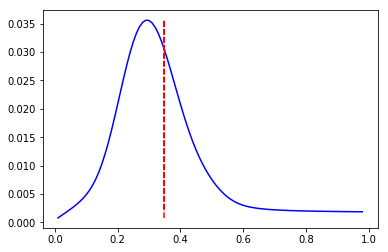

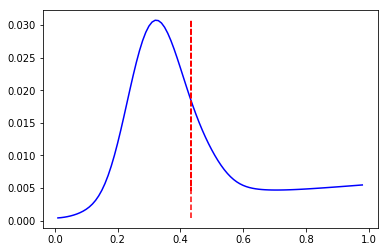

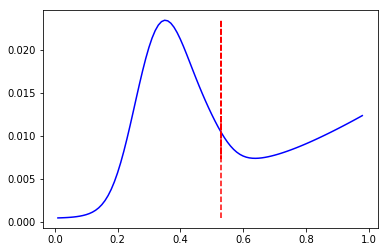

In [204]:
# There is a point of reversal ar around trial 100. We choose that. So we want the model to decrease its estimate of q.
a = list(range(99, 105, 1))
# plot prior probs against q tgt with the estimates of q
for i in range(99, 105):
    plt.plot(q, Bayes(H)[i], 'b-', eqplt[i], Bayes(H)[i], 'r--')
    plt.show()

As expected, the estimate wavers a bit before increasing. 

**2.2 Transition function**


What happens if we vary $H$?

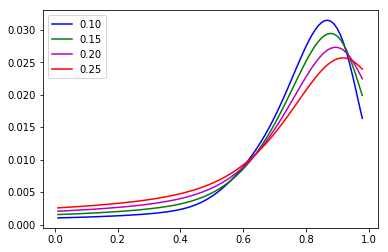

In [205]:
# plot prior for trial i for different values of H
# i = 50

plt.plot(q, Bayes(0.10)[50], 'b', label = "0.10")
plt.plot(q, Bayes(0.15)[50], 'g', label = "0.15")
plt.plot(q, Bayes(0.20)[50], 'm', label = "0.20")
plt.plot(q, Bayes(0.25)[50], 'r', label = "0.25")
plt.legend()
plt.show()

We have chosen a set of values of $H$ for which the prior distributions are similar enough to be compared easily. As $H$ increases in this set of values, the distribution becomes flatter. By increasing $H$, we increase the probability of $q$ having a uniform distribution, and decrease the probability of $q$ following the posterior distribution.  


**Brief Summary**


When the value of $H$ is low, the model's estimate of $q$ is stable, so is unable to 'learn' from the change in rewards quickly. Conversely, when $H$ is high, the model's estimate of $q$ is unstable, so is not very good during the trials for which the true value of $q$ is constant, but responds quickly at points of reversal. 